In [1]:
#Apply the trained models at random seed 0 (1 of the 10 re-trains), and save the output IT sshs. Plot some figures to check if they look all right.
#This applies to outputs with SST as inputs, de-gradted at different length scales. 
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import KFold
from copy import deepcopy
import utils
from unet import UNet_nobatchnorm
from scipy.stats import pearsonr
from pathlib import Path
import numpy.fft as fft
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import helper_functions as hf
from scipy.signal import convolve2d, convolve


In [2]:
root_dir = '/work/uo0780/u241359/project_tide_synergy/data/'
nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)
Ntrain = np.sum([nc.dimensions['time_counter'].size for nc in nctrains], axis = 0)
Ntest = np.sum([nc.dimensions['time_counter'].size for nc in nctest], axis = 0)

model_folder = '/work/uo0780/u241359/project_tide_synergy/trainedmodels_forpaper/'
iensemble = 0
vel_cmap  = 'BrBG' #'viridis'
vort_cmap = 'PRGn'
ssh_cmap  = 'bwr'
sst_cmap = 'inferno'

bottom_slice = slice(0,256)
mid_slice = slice(232, 488)
top_slice = slice(464, 720)

def corr(data, mod):
    return pearsonr(data.flatten(), mod.flatten())[0]
def L2_R(data,mod):
    return R2(data.flatten(), mod.flatten())
def performance_metrics(data, mod):
    return corr(data, mod), L2_R(data,mod)

In [3]:
Nbase = 16
def totorch(x):
    return torch.tensor(x, dtype = torch.float).cpu()
    
def preload_data(nctrains, total_records):
    #total_records = Ntrain#sum(nc.dimensions['time_counter'].size for nc in nctrains)
    #dimensions of data of the nc file.
    max_height = 722
    max_width = 258
    all_input_data = np.zeros((total_records, N_inp, max_height, max_width))*np.nan
    all_output_data = np.zeros((total_records, N_out, max_height, max_width))*np.nan
    current_index = 0
    for ncindex, ncdata in enumerate(nctrains):
        num_recs = ncdata.dimensions['time_counter'].size
        rec_slice = slice(current_index, current_index + num_recs)
        
        for ind, var_name in enumerate(var_input_names):
            data_slice = np.squeeze(ncdata.variables[var_name])
            # print('data_slice shape:')
            # print(data_slice.shape)        
            #all_input_data[rec_slice, ind, :, :] = data_slice
            #For some variables, the dimensions in (x, y) may be smaller than (max_height, max_width). Changing the code so that it adapts them.
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_input_data[rec_slice, ind, :slice_height, :slice_width] = data_slice
    

        for ind, var_name in enumerate(var_output_names):
            data_slice = np.squeeze(ncdata.variables[var_name])
            #all_output_data[rec_slice, ind, :, :] = data_slice
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_output_data[rec_slice, ind, :slice_height, :slice_width] = data_slice

        current_index += num_recs
        
    return all_input_data, all_output_data

# # Modify the loadtrain function to pull data from preloaded memory
# def loaddata_preloaded_train(index, batch_size, all_input_data, all_output_data):
#     rec_slice = slice(index, index + batch_size)
#     lim = 720
#     width = 256
#     yslice = slice(0, lim)
#     xslice = slice(0, width)
#     # print('rec_slice is:')
#     # print(rec_slice)
#     # print('mean of squared values of loaded input data:')
#     # print("{0:0.32f}".format(np.nanmean(all_input_data[rec_slice, :, yslice, xslice]**2)))
#     return (all_input_data[rec_slice, :, yslice, xslice], 
#             all_output_data[rec_slice, :, yslice, xslice])
#Load test data as one single batch
def loaddata_preloaded_test(all_input_data, all_output_data):
    #rec_slice = slice(index, index + batch_size)
    lim = 720
    width = 256
    yslice = slice(0, lim)
    xslice = slice(0, width)
    # print('rec_slice is:')
    # print(rec_slice)
    # print('mean of squared values of loaded input data:')
    # print("{0:0.32f}".format(np.nanmean(all_input_data[rec_slice, :, yslice, xslice]**2)))
    return (all_input_data[:, :, yslice, xslice], 
            all_output_data[:, :, yslice, xslice])


def load_variable(ncdata, ncindex, variable, rec_slice, yslice, xslice):
    data_squeezed = np.squeeze(ncdata[ncindex].variables[variable])
    return data_squeezed[rec_slice, yslice, xslice]

In [4]:
#Functions for low-pass filtering
def gaussian_kernel(decaylength): 
    """Generates a Gaussian kernel."""
    #decaylength is in the unit of grid resolution (4km in Aurelien's data.) So in physical units, the decay lenght would be decaylength*(4 km).
    size=int(2*decaylength)
    sigma=decaylength/(2*np.sqrt(2*np.log(2))) #Interpretting decaylength as the FWHM of Gaussian
    kernel = np.fromfunction(
        lambda x, y: (1 / np.sqrt(2 * np.pi * sigma ** 2)) * 
                      np.exp(-((x- size/2)**2 + (y-size/2)**2) / (2 * sigma ** 2)),
        (size, size)  
    ) #Creating a kernel with 
    return kernel / np.sum(kernel)  # Normalize the kernel
    
def degrade_space_gaussian(field, decaylength):
    nt, nx, ny = np.shape(field)
    kernel = gaussian_kernel(decaylength)
    filtered_field = np.empty([nt, nx, ny])

    for i in range(nt):
        filtered_field[i, : ,:] = convolve2d(field[i, : ,:], kernel, mode = 'same', boundary='symm')#,  fillvalue = np.average(field[i, : ,:]))
    return filtered_field

# Load all data into memory; no normalization is done here yet.
# Apply a spatial lowpass filter to the temperature field 'T_xy_ins'
# decayunits is how many units of grid spacing is the decay length scale. A grid spacing is 4km in Aurelien's data. So in physical units, the decay lenght would be decayunits*(4 km).
def preload_data_filterT(nctrains, total_records,decayunits=25,plot=True):
    #total_records = Ntrain#sum(nc.dimensions['time_counter'].size for nc in nctrains)
    #dimensions of data of the nc file.
    max_height = 722
    max_width = 258
    all_input_data = np.zeros((total_records, N_inp, max_height, max_width))*np.nan
    all_output_data = np.zeros((total_records, N_out, max_height, max_width))*np.nan
    current_index = 0
    for ncindex, ncdata in enumerate(nctrains):
        num_recs = ncdata.dimensions['time_counter'].size
        rec_slice = slice(current_index, current_index + num_recs)
        
        for ind, var_name in enumerate(var_input_names):
            data_slice = np.squeeze(ncdata.variables[var_name])
            # print('data_slice shape:')
            # print(data_slice.shape)        
            #Turns out to be (time, height, width)
            # print('var_name:')
            # print(var_name)
            # Apply lowpass filter when the field is 'T_xy_ins'
            if var_name == 'T_xy_ins':
                if plot == True:
                    #Plot an image before the filter
                    itime=20        
                    cmapmax=np.max(data_slice[itime,:,:])
                    cmapmin=np.min(data_slice[itime,:,:])
                    figT, axT = plt.subplots(1, 2, figsize=(5, 5))
                    figT.set_dpi(256)   
                    im0=axT[0].pcolor(data_slice[itime,:,:],vmin=cmapmin,vmax=cmapmax)
                    axT[0].set_aspect(1)
                #Lowpass filter
                data_slice=degrade_space_gaussian(data_slice,decayunits)
                if plot == True:
                    axT[1].pcolor(data_slice[itime,:,:],vmin=cmapmin,vmax=cmapmax)
                    axT[1].set_aspect(1)
                    cbar0=plt.colorbar(im0, ax=axT, fraction=0.046, pad=0.04)
            
            #For some variables, the dimensions in (x, y) may be smaller than (max_height, max_width). Changing the code so that it adapts them.
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_input_data[rec_slice, ind, :slice_height, :slice_width] = data_slice
    

        for ind, var_name in enumerate(var_output_names):
            data_slice = np.squeeze(ncdata.variables[var_name])
            if var_name == 'T_xy_ins':
                if plot == True:
                    #Plot an image before the filter
                    itime=20        
                    cmapmax=np.max(data_slice[itime,:,:])
                    cmapmin=np.min(data_slice[itime,:,:])
                    figT, axT = plt.subplots(1, 2, figsize=(5, 5))
                    figT.set_dpi(256)   
                    im0=axT[0].pcolor(data_slice[itime,:,:],vmin=cmapmin,vmax=cmapmax)
                    axT[0].set_aspect(1)
                #Lowpass filter
                
                data_slice=degrade_space_gaussian(data_slice,decayunits)
                if plot == True:
                    axT[1].pcolor(data_slice[itime,:,:],vmin=cmapmin,vmax=cmapmax)
                    axT[1].set_aspect(1)
                    cbar0=plt.colorbar(im0, ax=axT, fraction=0.046, pad=0.04)
            #all_output_data[rec_slice, ind, :, :] = data_slice
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_output_data[rec_slice, ind, :slice_height, :slice_width] = data_slice

        current_index += num_recs
        
    return all_input_data, all_output_data


In [5]:
decayunits=25 #The best SST satellite has a resolution of 9 km. It may be safe to set decayunits to be 20 km to be already resolvable by satellites

vi1 = 'ssh_ins'
vi2 = 'T_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

batch_size = 80 #maximizing it so that the GPU memory maxes out. Needs to be divisible by Ntrain. Otherwise there will be size mismatch issues.
lr0 = 0.005*10/batch_size #Roughly should scale inversely to batch_size

var_input_names = [vi1, vi2]
var_output_names = [vo1, vo2]
N_inp = len(var_input_names)
N_out = len(var_output_names)

save_fn_prefix  = 'any_{}{}_{}{}_nobatchnorm_degradeT_du_{}'.format(vi1, vi2, vo1, vo2, decayunits)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data_filterT(nctrains, Ntrain, decayunits=decayunits,plot=False)
all_test_input, all_test_output = preload_data_filterT(nctest, Ntest, decayunits=decayunits,plot=False)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

fstr = f'{save_fn_prefix}_rp_{iensemble}' 
model_filename = f'/{fstr}.pth'
model_path = model_folder+ model_filename
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
HT_du25_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 0.03307104 25.14131302] [0.3119807 0.3304063]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]


/tmp/ipykernel_3104831/2575257485.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


(np.float64(0.8431786070847735), 0.7086287318589277) total panel
(np.float64(0.9752632168156888), 0.9487640215530002) bottom  panel
(np.float64(0.767387472948802), 0.587439182532423) mid  panel
(np.float64(0.7885230092564922), 0.6167937437989768) top  panel


In [6]:
decayunits=5 #The best SST satellite has a resolution of 9 km. It may be safe to set decayunits to be 20 km to be already resolvable by satellites

vi1 = 'ssh_ins'
vi2 = 'T_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

batch_size = 80 #maximizing it so that the GPU memory maxes out. Needs to be divisible by Ntrain. Otherwise there will be size mismatch issues.
lr0 = 0.005*10/batch_size #Roughly should scale inversely to batch_size

var_input_names = [vi1, vi2]
var_output_names = [vo1, vo2]
N_inp = len(var_input_names)
N_out = len(var_output_names)

save_fn_prefix  = 'any_{}{}_{}{}_nobatchnorm_degradeT_du_{}'.format(vi1, vi2, vo1, vo2, decayunits)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data_filterT(nctrains, Ntrain, decayunits=decayunits,plot=False)
all_test_input, all_test_output = preload_data_filterT(nctest, Ntest, decayunits=decayunits,plot=False)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

fstr = f'{save_fn_prefix}_rp_{iensemble}' 
model_filename = f'/{fstr}.pth'
model_path = model_folder+ model_filename
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
HT_du5_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 0.03307104 25.14131891] [0.3119807  0.33904831]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]


/tmp/ipykernel_3104831/1653911985.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


(np.float64(0.8526952688180548), 0.725308388350697) total panel
(np.float64(0.976873353692018), 0.9515991836640566) bottom  panel
(np.float64(0.7866962176507647), 0.6181002845058898) mid  panel
(np.float64(0.7884474599826946), 0.6188075102000623) top  panel


2880


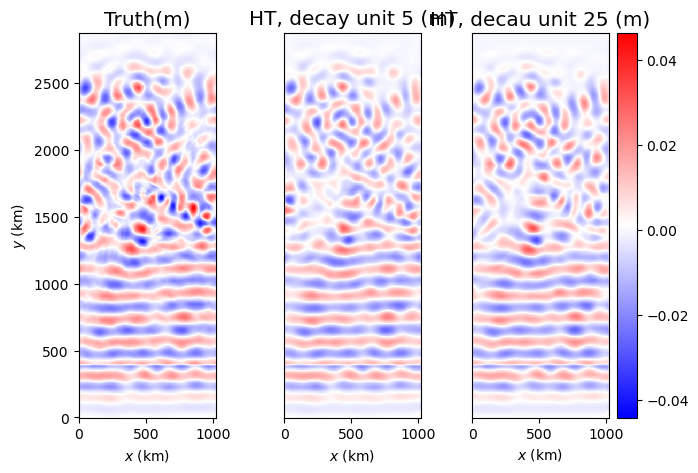

In [7]:
snap_index = 100
HT_du5_wave = HT_du5_out_mod[snap_index,0,:, : ]
HT_du25_wave = HT_du25_out_mod[snap_index,0,:, : ]
true_wave = out_test[snap_index,0,:, : ]

ny, nx = np.shape(true_wave)
dx = 4
Lx = nx*dx
Ly = ny*dx
print (Ly)

x_axis = np.arange(0, Lx, dx)
y_axis = np.arange(0, Ly, dx)
extent = [np.min(x_axis), np.max(x_axis), np.min(y_axis), np.max(y_axis)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (7.5,5))

clims = (np.min(true_wave), np.max(true_wave))

im1 = ax1.pcolor(x_axis, y_axis, true_wave, cmap=ssh_cmap, clim =clims)
ax1.set_title(r'Truth(m)',fontsize ='x-large')
# fig.colorbar(im1, ax = ax1)

im2 = ax2.pcolor(x_axis, y_axis, HT_du5_wave, cmap=ssh_cmap, clim =clims)
ax2.set_title('HT, decay unit 5 (m)',fontsize ='x-large')
# fig.colorbar(im2, ax = ax2)

ax2.get_yaxis().set_visible(False)

im3 = ax3.pcolor(x_axis, y_axis, HT_du25_wave, cmap=ssh_cmap, clim =clims)
ax3.set_title(r'HT, decau unit 25 (m)',fontsize ='x-large')
fig.colorbar(im1, ax = ax3)
ax3.get_yaxis().set_visible(False)

# rect_orig = (78, 65)
# rect_size = 80
zoom_x1, zoom_x2 = 75, 160  # Example coordinates for zoomed-in section
zoom_y1, zoom_y2 = 325, 410

extent = [zoom_x1, zoom_x2, zoom_y1, zoom_y2]
zoom_width = "70%"

ax1.set_xlabel(r'$x$ (km)') 
ax1.set_ylabel(r'$y$ (km)') 
ax2.set_xlabel(r'$x$ (km)') 
ax3.set_xlabel(r'$x$ (km)') 

ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

plt.show()

In [8]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
decayunits=25 #The best SST satellite has a resolution of 9 km. It may be safe to set decayunits to be 20 km to be already resolvable by satellites

vi1 = 'T_xy_ins'
vi2 = 'u_xy_ins'
vi3 = 'v_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'


batch_size = 60 #maximizing it so that the GPU memory maxes out. Needs to be divisible by Ntrain. Otherwise there will be size mismatch issues.
lr0 = 0.005*10/batch_size #Roughly should scale inversely to batch_size


var_input_names = [vi1, vi2, vi3]
var_output_names = [vo1, vo2]
N_inp = len(var_input_names)
N_out = len(var_output_names)

save_fn_prefix  = 'any_{}{}{}_{}{}_nobatchnorm_degradeT_du_{}'.format(vi1, vi2, vi3, vo1, vo2, decayunits)
nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑


all_train_input, all_train_output = preload_data_filterT(nctrains, Ntrain, decayunits=decayunits,plot=False)
all_test_input, all_test_output = preload_data_filterT(nctest, Ntest, decayunits=decayunits,plot=False)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

fstr = f'{save_fn_prefix}_rp_{iensemble}' 
model_filename = f'/{fstr}.pth'
model_path = model_folder+ model_filename
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
UT_du25_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 2.51413130e+01  3.56612545e-02 -1.90587743e-03] [0.3304063  0.04679374 0.04875586]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]


/tmp/ipykernel_3104831/175093398.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


(np.float64(0.9460450223619531), 0.8948850357320088) total panel
(np.float64(0.9929900279308619), 0.985375443075615) bottom  panel
(np.float64(0.9087518910697411), 0.82581030779161) mid  panel
(np.float64(0.9597501100696124), 0.914040324540346) top  panel


In [9]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
decayunits=25 #The best SST satellite has a resolution of 9 km. It may be safe to set decayunits to be 20 km to be already resolvable by satellites

vi1 = 'ssh_ins'
vi2 = 'T_xy_ins'
vi3 = 'u_xy_ins'
vi4 = 'v_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

batch_size = 50 #maximizing it so that the GPU memory maxes out. Needs to be divisible by Ntrain. Otherwise there will be size mismatch issues.
lr0 = 0.005*10/batch_size #Roughly should scale inversely to batch_size

var_input_names = [vi1, vi2, vi3, vi4]
var_output_names = [vo1, vo2]
N_inp = len(var_input_names)
N_out = len(var_output_names)

save_fn_prefix  = 'any_{}{}{}{}_{}{}_nobatchnorm_degradeT_du_{}'.format(vi1, vi2, vi3, vi4, vo1, vo2, decayunits)
nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑


all_train_input, all_train_output = preload_data_filterT(nctrains, Ntrain, decayunits=decayunits,plot=False)
all_test_input, all_test_output = preload_data_filterT(nctest, Ntest, decayunits=decayunits,plot=False)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

fstr = f'{save_fn_prefix}_rp_{iensemble}' 
model_filename = f'/{fstr}.pth'
model_path = model_folder+ model_filename
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
HUT_du25_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 3.30710389e-02  2.51413130e+01  3.56612545e-02 -1.90587743e-03] [0.3119807  0.3304063  0.04679374 0.04875586]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]


/tmp/ipykernel_3104831/3774275338.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


(np.float64(0.9724666222969927), 0.9449445988437642) total panel
(np.float64(0.9952457217022237), 0.9883269273584491) bottom  panel
(np.float64(0.9560411503929392), 0.9128617696851948) mid  panel
(np.float64(0.9797504575338205), 0.9559218999117458) top  panel


In [10]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
decayunits=5 #The best SST satellite has a resolution of 9 km. It may be safe to set decayunits to be 20 km to be already resolvable by satellites

vi1 = 'T_xy_ins'
vi2 = 'u_xy_ins'
vi3 = 'v_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'


batch_size = 60 #maximizing it so that the GPU memory maxes out. Needs to be divisible by Ntrain. Otherwise there will be size mismatch issues.
lr0 = 0.005*10/batch_size #Roughly should scale inversely to batch_size


var_input_names = [vi1, vi2, vi3]
var_output_names = [vo1, vo2]
N_inp = len(var_input_names)
N_out = len(var_output_names)

save_fn_prefix  = 'any_{}{}{}_{}{}_nobatchnorm_degradeT_du_{}'.format(vi1, vi2, vi3, vo1, vo2, decayunits)
nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑


all_train_input, all_train_output = preload_data_filterT(nctrains, Ntrain, decayunits=decayunits,plot=False)
all_test_input, all_test_output = preload_data_filterT(nctest, Ntest, decayunits=decayunits,plot=False)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

fstr = f'{save_fn_prefix}_rp_{iensemble}' 
model_filename = f'/{fstr}.pth'
model_path = model_folder+ model_filename
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
UT_du5_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 2.51413189e+01  3.56612545e-02 -1.90587743e-03] [0.33904831 0.04679374 0.04875586]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]


/tmp/ipykernel_3104831/4281177547.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


(np.float64(0.9491997877985168), 0.9008359206479941) total panel
(np.float64(0.9925376630232506), 0.9845243852090122) bottom  panel
(np.float64(0.9150606047426184), 0.837288563964367) mid  panel
(np.float64(0.9627569442149625), 0.9208194772065345) top  panel


In [11]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
decayunits=5 #The best SST satellite has a resolution of 9 km. It may be safe to set decayunits to be 20 km to be already resolvable by satellites

vi1 = 'ssh_ins'
vi2 = 'T_xy_ins'
vi3 = 'u_xy_ins'
vi4 = 'v_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

batch_size = 50 #maximizing it so that the GPU memory maxes out. Needs to be divisible by Ntrain. Otherwise there will be size mismatch issues.
lr0 = 0.005*10/batch_size #Roughly should scale inversely to batch_size

var_input_names = [vi1, vi2, vi3, vi4]
var_output_names = [vo1, vo2]
N_inp = len(var_input_names)
N_out = len(var_output_names)

save_fn_prefix  = 'any_{}{}{}{}_{}{}_nobatchnorm_degradeT_du_{}'.format(vi1, vi2, vi3, vi4, vo1, vo2, decayunits)
nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑


all_train_input, all_train_output = preload_data_filterT(nctrains, Ntrain, decayunits=decayunits,plot=False)
all_test_input, all_test_output = preload_data_filterT(nctest, Ntest, decayunits=decayunits,plot=False)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

fstr = f'{save_fn_prefix}_rp_{iensemble}' 
model_filename = f'/{fstr}.pth'
model_path = model_folder+ model_filename
state_dict = torch.load(model_path)

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
HUT_du5_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[ 3.30710389e-02  2.51413189e+01  3.56612545e-02 -1.90587743e-03] [0.3119807  0.33904831 0.04679374 0.04875586]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]


/tmp/ipykernel_3104831/2859096102.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


(np.float64(0.9738466129357716), 0.9483542235925433) total panel
(np.float64(0.9956098361071262), 0.9898249792822966) bottom  panel
(np.float64(0.9586853727500718), 0.9188600105215126) mid  panel
(np.float64(0.9795030173696497), 0.9557453121102328) top  panel


In [12]:
#Create an array that saves all the outputs. 
print(HUT_du5_out_mod.shape)

all_outputs = [HT_du5_out_mod, HT_du25_out_mod, UT_du5_out_mod, UT_du25_out_mod, HUT_du5_out_mod, HUT_du25_out_mod]
outputs_cosssh_HUTcomb =  np.stack([array[:, 0, :, :] for array in all_outputs], axis=0)
outputs_sinssh_HUTcomb =  np.stack([array[:, 1, :, :] for array in all_outputs], axis=0)

print(outputs_cosssh_HUTcomb.shape)

(150, 2, 720, 256)
(6, 150, 720, 256)


0.8214422612295982
0.7674898776087353
0.871668534762817
0.8660079035182359
0.9683376608613731
0.9609867660241309


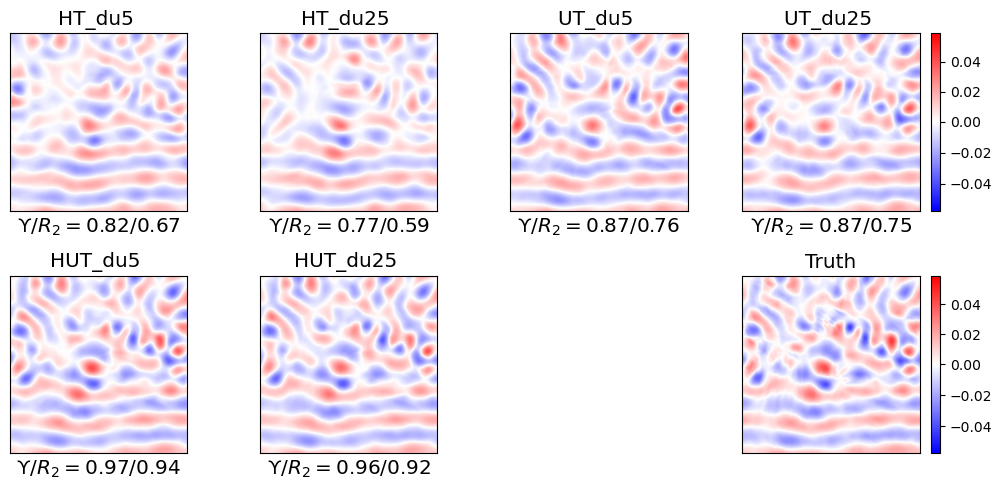

In [13]:
field_max = np.max(outputs_cosssh_HUTcomb)
field_min = np.min(outputs_cosssh_HUTcomb)
truth_snapshot = out_test[snap_index, 0]
model_ordering = ['HT_du5', 'HT_du25','UT_du5', 'UT_du25', 'HUT_du5', 'HUT_du25']
fig=plt.figure(figsize = (10.5,5))
norm = TwoSlopeNorm(vcenter =0)
for i in range(6):
    plt.subplot(2, 4,i+1)
    plt.imshow(outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :], origin ='lower', cmap = ssh_cmap, norm=norm)
#     plt.colorbar()
    plt.clim(field_min, field_max)
    correlation = corr(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
    coeff_determ = L2_R(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
    print (correlation)
#     plt.text(40, 20, r'$\mathcal{\Upsilon}$ = ' +  str(round(correlation, 2)), fontsize = 'x-large')
#     plt.text(40, 60, r'$R_2$ = ' +  str(round(coeff_determ, 2)), fontsize = 'x-large')
    plt.xlabel(r'$\mathcal{\Upsilon}/R_2 = $'+ str(round(correlation, 2))+'/'+str(round(coeff_determ, 2)),
               fontsize = 'x-large')
    plt.xticks([])
    plt.yticks([])
    if i==3:
        plt.colorbar()

    plt.title('{} '.format(model_ordering[i]), fontsize = 'x-large')
plt.subplot(2,4,8)
plt.imshow(truth_snapshot[mid_slice, :] , origin ='lower', cmap = ssh_cmap, norm =norm)
plt.colorbar()
plt.title('Truth',  fontsize = 'x-large')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
# plt.title('{} '.format(to_ssh_model_names[i]), fontsize = 'xx-large')
# fig.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

In [14]:
#Save outputs
modeloutput_dir = '/work/uo0780/u241359/project_tide_synergy/model_outputs/'
np.savez(modeloutput_dir+'FilteredTcombs_UNet', HT_du5_out_mod, HT_du25_out_mod, UT_du5_out_mod, UT_du25_out_mod, HUT_du5_out_mod, HUT_du25_out_mod) 
#npz = np.load('data/temp/np_savez.npz')
#Access the stored arrays by specifying their names within []. The names of each array can be checked using the files attribute.
#print(npz.files)
# ['arr_0', 'arr_1']
#print(npz['arr_0'])
# [0 1 2 3 4]

In [15]:
#save input T
#Save input T. Just using some previous code for the U-Net training, deleting the training part. It's not optimized but works.

decayunits=25 #The best SST satellite has a resolution of 9 km. It may be safe to set decayunits to be 20 km to be already resolvable by satellites

vi1 = 'T_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

var_input_names = [vi1]
var_output_names = [vo1, vo2]
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data_filterT(nctrains, Ntrain, decayunits=decayunits,plot=False)
all_test_input, all_test_output = preload_data_filterT(nctest, Ntest, decayunits=decayunits,plot=False)

T_du25_train = all_train_input
T_du25_test = all_test_input

In [16]:
print(T_du25_train.shape)
print(T_du25_test.shape) 

(600, 1, 722, 258)
(150, 1, 722, 258)


In [17]:
decayunits=5 #The best SST satellite has a resolution of 9 km. It may be safe to set decayunits to be 20 km to be already resolvable by satellites

vi1 = 'T_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

var_input_names = [vi1]
var_output_names = [vo1, vo2]
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data_filterT(nctrains, Ntrain, decayunits=decayunits,plot=False)
all_test_input, all_test_output = preload_data_filterT(nctest, Ntest, decayunits=decayunits,plot=False)

T_du5_train = all_train_input
T_du5_test = all_test_input

In [19]:
#Unfiltered T
vi1 = 'T_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}_{}{}_nobatchnorm'.format(vi1, vo1, vo2)
var_input_names = [vi1]
var_output_names = [vo1, vo2]

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data(nctrains, Ntrain)
all_test_input, all_test_output = preload_data(nctest, Ntest)

T_raw_train = all_train_input
T_raw_test = all_test_input

In [20]:
np.savez(modeloutput_dir+'inputT_filtered', T_raw_train, T_raw_test, T_du5_train, T_du5_test, T_du25_train, T_du25_test) 